In [1]:
import numpy as np
import identity_exchange_profiler as iep
import matplotlib.pyplot as plt

In [3]:
def generate_flip_flop_data(n_traces=100, n_frames=1000, noise_prob=0.1, 
                            min_segment_len=10, max_segment_len=100, seed=None):
    """
    Generate temporally structured traces with noise.
    
    Parameters:
    -----------
    n_traces : int
        Number of traces to generate
    n_frames : int
        Number of frames per trace
    noise_prob : float
        Probability of a frame being noise (label 0)
    min_segment_len : int
        Minimum length of structured segments (labels 1, 2, 3)
    max_segment_len : int
        Maximum length of structured segments
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    traces : np.ndarray
        Array of shape (n_traces, n_frames) with labels 0, 1, 2, 3
    """
    if seed is not None:
        np.random.seed(seed)
    
    traces = np.zeros((n_traces, n_frames), dtype=np.int32)
    
    for i in range(n_traces):
        pos = 0
        
        # Fill trace with structured segments
        while pos < n_frames:
            # Random segment length
            seg_len = np.random.randint(min_segment_len, max_segment_len + 1)
            seg_len = min(seg_len, n_frames - pos)  # Don't exceed trace length
            
            # Random label (1, 2, or 3)
            label = np.random.randint(1, 4)
            
            # Fill segment
            traces[i, pos:pos + seg_len] = label
            pos += seg_len
        
        # Add noise (label 0) randomly
        noise_mask = np.random.random(n_frames) < noise_prob
        traces[i, noise_mask] = 0
    
    return traces.T

## Generating flip-flop data

In [4]:
test_segmentation = generate_flip_flop_data(
    n_traces=100, 
    n_frames=10000, 
    noise_prob=0.01,  # 10% noise
    min_segment_len=10,
    max_segment_len=1000,
    seed=42  # For reproducibility
)

## Using MDVoxelSegmentation in combination with MDAnalysis
```
gro = 'your.tpr'
xtc = 'your.xtc' 
segmentation_data = 'clusters.npy'
```

```
u = mda.Universe(gro, xtc)
segmentation = np.load(segmentation_data)
```

In [5]:


# Segments to check flips between
segment_A = 1
segment_B = 2

# Pre-filtering to reduce noise due to low certainty
fuzzy_width = 5 # n frames to use for calculating fuzzy label assignment 
fuzzy_cutoff = .5 # the average relabeled frame annotation {-1, 0, 1} over the fuzzy width to use as threshold to set label

# Pre-filtering to only takes frames into account which have both labels present (useful for lipid flip-flop)
mask_valid_frames = True

# Post-processing to fill in the removed frames due to the fact that not both labels where present (respecting the total sum)
blib_processing = True

# Time indication
skip = 10 # Every nth frame to take into account
dt = 1.0 * skip # is expected to be in ps

# Set the segmentation data to use
selected_segmentation = np.copy(test_segmentation)

# Verbosity if said to True be loud and noisy
verbose = True

# Run analysis
analysis = iep.Profiler(
    segmentation=selected_segmentation[::skip],
    segment_A=segment_A,
    segment_B=segment_B,
    fuzzy_width=fuzzy_width, 
    fuzzy_cutoff=fuzzy_cutoff,
    mask_valid_frames=mask_valid_frames,
    blib_processing=blib_processing,
    dt=dt,
    verbose=verbose,
)

In [6]:
analysis.compute()

Applying segment masks...
Masking frames without both segments...
Running flip detection...
Frame: 1000/1000         
Detected 643 flips
Calculating flip time series...
Smearing blib signals...
Analysis complete!

RESIDUE EXCHANGE SUMMARY
Total flips (segment 1 → 2): 319
Total flips (segment 2 → 1): 324
Net exchange 1 → 2: -5
Frames analyzed: 1000
Residues tracked: 100
Total flip events detected: 643



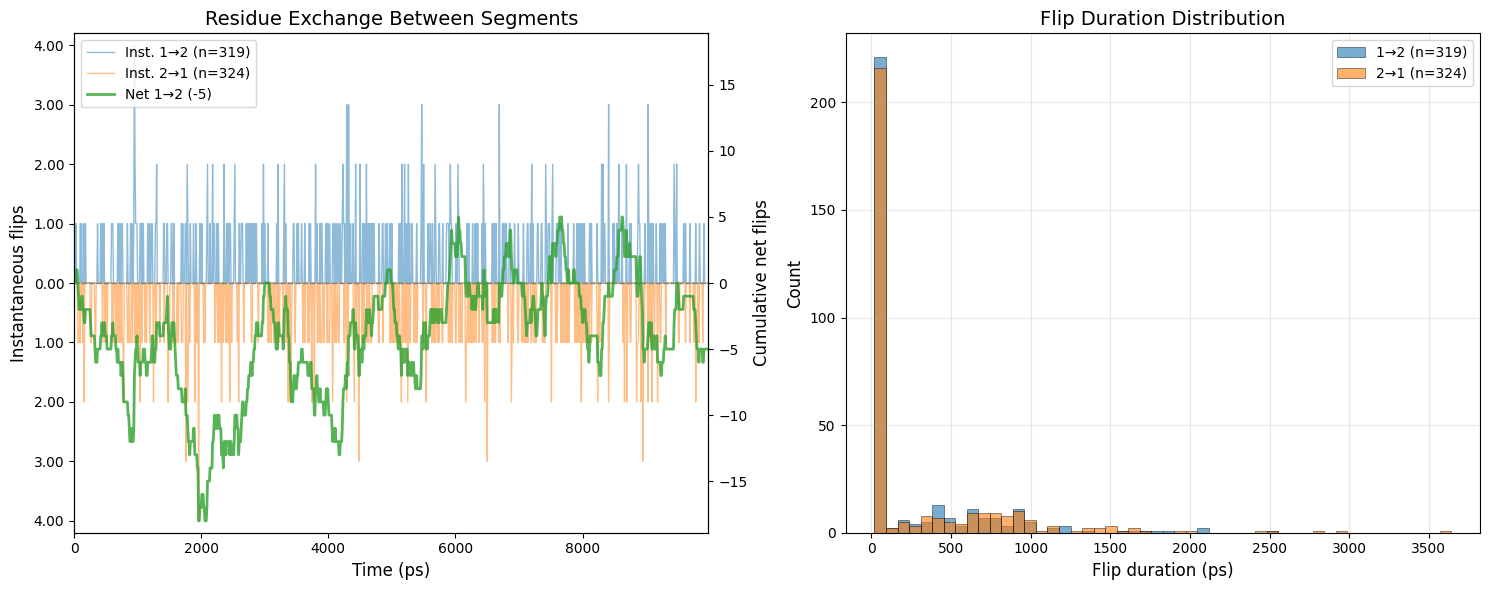

In [7]:
plot  = analysis.plot(time_units=('ps', 'ps'))

In [8]:
#TODO There is currently no easy way to plot the filtered flips.
# Filter flips which are closer together than n frames ()
filtered_flips = iep.Profiler.filter_close_events(analysis.flips, threshold=1)
diff = len(analysis.flips) - len(filtered_flips)
print(f'Filtered {diff} flips due to unstable end points.')

Filtered 12 flips due to unstable end points.


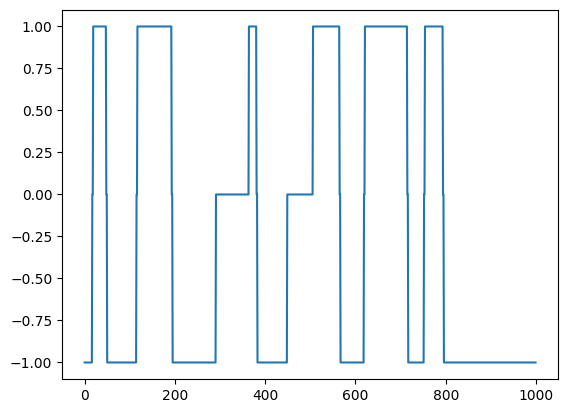

Start Stop Duration Sign TraceID
[[ 16  19   2   1  95]
 [ 47  50   2  -1  95]
 [114 117   2   1  95]
 [192 195   2  -1  95]
 [290 364  73   1  95]
 [380 383   2  -1  95]
 [448 506  57   1  95]
 [564 567   2  -1  95]
 [618 621   2   1  95]
 [714 717   2  -1  95]
 [751 754   2   1  95]
 [793 796   2  -1  95]]


In [9]:
# Example to find a trace which flips the most
max_flips_trace = analysis.flip_counts[np.argmax(analysis.flip_counts[:,1])][0]
# Plot only the frames in which A and B are present for a max flip trace
plt.plot(analysis.masked_segmentation[:, max_flips_trace][analysis.valid_mask])
plt.show()
# Find the residue number for a most flipping particle
#print(selection_atomgroup.residues[max_flips_trace])
#print(f'Atom indices {selection_atomgroup.residues[max_flips_trace].atoms.ix}')
print('Start Stop Duration Sign TraceID')
print(analysis.flips[np.where(analysis.flips[:,4] == max_flips_trace)])

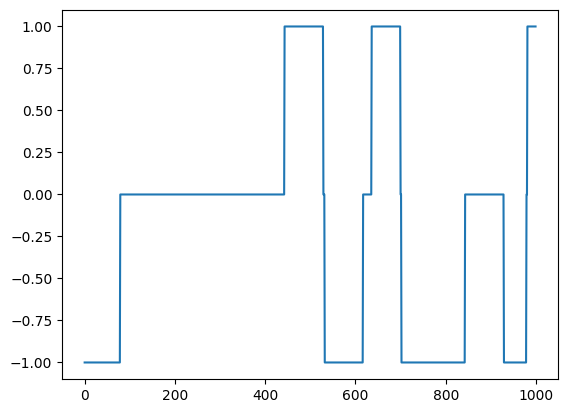

Start Stop Duration Sign TraceID
[[ 78 443 364   1  63]
 [528 532   3  -1  63]
 [616 636  19   1  63]
 [699 702   2  -1  63]
 [978 981   2   1  63]]


In [10]:
# Example to find a trace which flips the longest
longest_flip_trace = analysis.flips[np.argmax(analysis.flips[:,2])][4]
# Plot only the frames in which A and B are present for a max flip duration trace
plt.plot(analysis.masked_segmentation[:, longest_flip_trace][analysis.valid_mask])
plt.show()
# Find the residue number for a longest flipping particle
#print(selection_atomgroup.residues[longest_flip_trace])
#print(f'Atom indices {selection_atomgroup.residues[longest_flip_trace].atoms.ix}')
print('Start Stop Duration Sign TraceID')
print(analysis.flips[np.where(analysis.flips[:,4] == longest_flip_trace)])